<a href="https://colab.research.google.com/github/HevertonCoutinho/reconhecimento-facial/blob/main/Reconhecimento_Facial_M%C3%A9todos_tradicionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento facial com métodos tradicionais

Três técnicas diferentes:

* Eigenfaces
* Fisherfaces
* LBPH - Local Binary Pattern Histogram

## Importação das bibliotecas

In [ ]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

## Carregamento da base de dados

- Yalefaces: http://vision.ucsd.edu/content/yale-face-database

In [ ]:
import zipfile
path = '/content/yalefaces.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
import os
print(os.listdir('/content/yalefaces/train'))

['subject08.wink.gif', 'subject12.centerlight.gif', 'subject07.wink.gif', 'subject09.happy.gif', 'subject03.sleepy.gif', 'subject13.surprised.gif', 'subject11.leftlight.gif', 'subject08.centerlight.gif', 'subject14.centerlight.gif', 'subject10.rightlight.gif', 'subject14.happy.gif', 'subject01.leftlight.gif', 'subject11.noglasses.gif', 'subject09.noglasses.gif', 'subject09.sleepy.gif', 'subject15.sleepy.gif', 'subject15.wink.gif', 'subject07.sleepy.gif', 'subject14.rightlight.gif', 'subject04.centerlight.gif', 'subject10.leftlight.gif', 'subject07.glasses.gif', 'subject15.surprised.gif', 'subject14.wink.gif', 'subject14.surprised.gif', 'subject12.noglasses.gif', 'subject08.surprised.gif', 'subject12.happy.gif', 'subject06.surprised.gif', 'subject10.happy.gif', 'subject04.sleepy.gif', 'subject04.glasses.gif', 'subject01.rightlight.gif', 'subject02.glasses.gif', 'subject13.rightlight.gif', 'subject05.wink.gif', 'subject09.surprised.gif', 'subject05.normal.gif', 'subject01.surprised.gif',

In [ ]:
imagem_teste = '/content/yalefaces/train/subject01.leftlight.gif'
#convertendo imagem para escala de cinza
imagem = Image.open(imagem_teste).convert('L')
type(imagem)

PIL.Image.Image

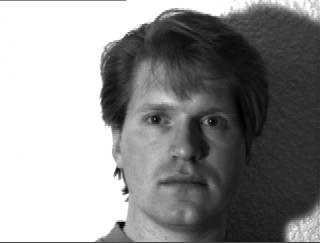

In [ ]:
imagem

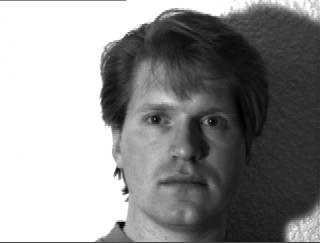

(243, 320)


In [ ]:
#convertendo imagem PIL para Numpy em inteiro
imagem_np = np.array(imagem, 'uint8')
cv2_imshow(imagem_np)
print(imagem_np.shape)

In [ ]:
243 * 320

77760

## Detecção de faces

In [ ]:
#carregando rede neural SSD
network = cv2.dnn.readNetFromCaffe('/content/deploy.prototxt.txt', '/content/res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
#Definindo as dimenções da imagem
imagem = cv2.cvtColor(imagem_np, cv2.COLOR_GRAY2BGR)
(h, w) = imagem.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (100, 100)), 1.0, (100,100), (104.0, 117.0, 123.0))
network.setInput(blob)
deteccoes = network.forward()

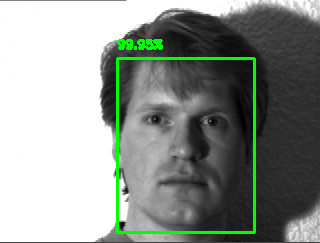

(243, 320, 3)


In [ ]:
conf_min = 0.7
imagem_cp = imagem.copy()
for i in range(0, deteccoes.shape[2]):
  confianca = deteccoes[0, 0, i, 2]
  if confianca > conf_min:
    bbox = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
    (start_x, start_y, end_x, end_y) = bbox.astype('int')
    #copiando para a variavel roi a regiao de interesse
    roi = imagem_cp[start_y:end_y, start_x:end_x]
    text = "{:.2f}%".format(confianca * 100)
    cv2.putText(imagem, text, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
    cv2.rectangle(imagem, (start_x, start_y), (end_x, end_y), (0,255,0), 2)
face = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
cv2_imshow(imagem)
print(imagem.shape)

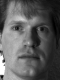

(80, 60)


In [ ]:
face = cv2.resize(face, (60,80))
cv2_imshow(face)
print(face.shape)

In [ ]:
def detecta_face(network, path_imagem, conf_min = 0.7):
  imagem = Image.open(path_imagem).convert('L')
  imagem = np.array(imagem, 'uint8')
  imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
  (h, w) = imagem.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (100, 100)), 1.0, (100,100), (104.0, 117.0, 123.0))
  network.setInput(blob)
  deteccoes = network.forward()

  face = None
  for i in range(0, deteccoes.shape[2]):
    confianca = deteccoes[0, 0, i, 2]
    if confianca > conf_min:
      bbox = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
      (start_x, start_y, end_x, end_y) = bbox.astype('int')
      roi = imagem[start_y:end_y, start_x:end_x]
      roi = cv2.resize(roi, (60,80))
      cv2.rectangle(imagem, (start_x, start_y), (end_x, end_y), (0,255,0), 2)
      face = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  return face, imagem

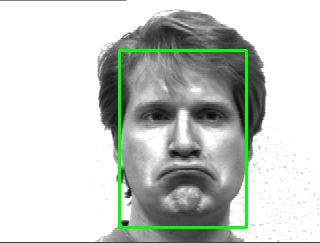

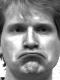

In [ ]:
teste_imagem = '/content/yalefaces/train/subject01.sad.gif'
face, imagem = detecta_face(network, teste_imagem)
cv2_imshow(imagem)
cv2_imshow(face)

## Construção da base de dados

In [ ]:
def get_image_data():
  paths = [os.path.join('/content/yalefaces/train', f) for f in os.listdir('/content/yalefaces/train')]
  #print(paths)
  faces = []
  ids = []
  for path in paths:
    face, imagem = detecta_face(network, path)
    #cv2_imshow(imagem)
    #cv2_imshow(face)
    #print(path)
    id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    #print(id)
    ids.append(id)
    faces.append(face)
    cv2_imshow(face)
  return np.array(ids), faces

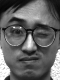

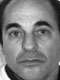

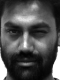

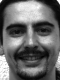

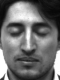

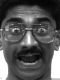

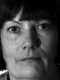

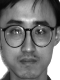

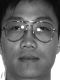

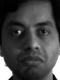

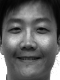

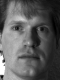

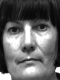

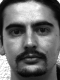

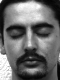

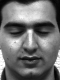

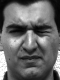

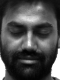

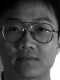

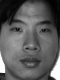

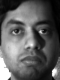

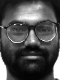

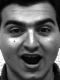

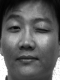

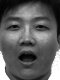

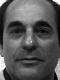

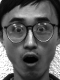

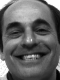

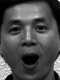

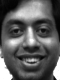

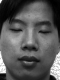

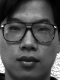

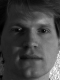

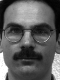

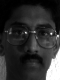

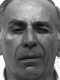

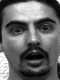

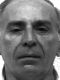

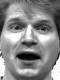

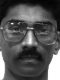

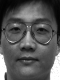

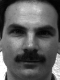

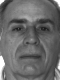

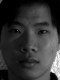

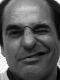

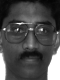

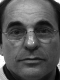

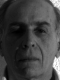

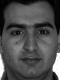

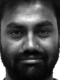

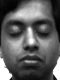

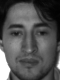

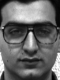

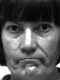

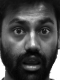

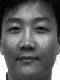

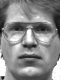

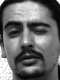

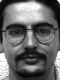

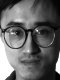

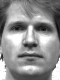

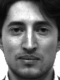

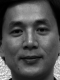

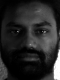

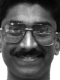

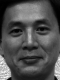

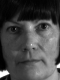

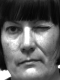

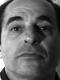

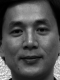

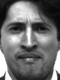

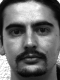

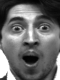

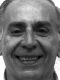

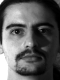

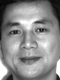

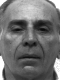

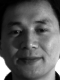

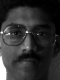

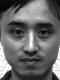

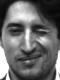

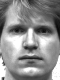

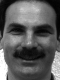

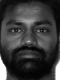

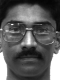

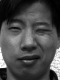

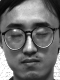

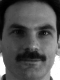

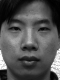

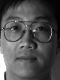

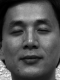

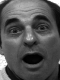

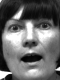

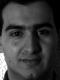

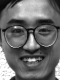

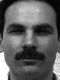

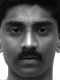

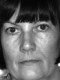

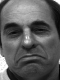

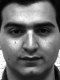

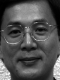

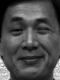

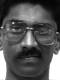

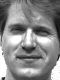

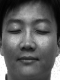

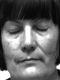

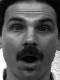

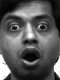

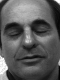

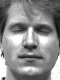

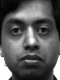

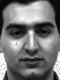

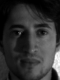

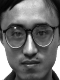

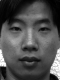

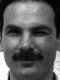

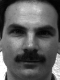

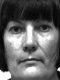

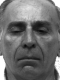

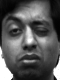

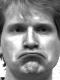

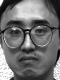

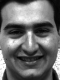

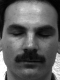

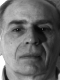

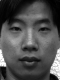

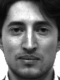

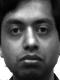

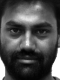

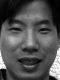

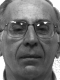

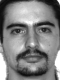

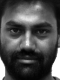

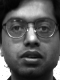

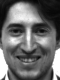

In [ ]:
ids, faces = get_image_data()

In [ ]:
ids

array([ 8, 12,  7,  9,  3, 13, 11,  8, 14, 10, 14,  1, 11,  9,  9, 15, 15,
        7, 14,  4, 10,  7, 15, 14, 14, 12,  8, 12,  6, 10,  4,  4,  1,  2,
       13,  5,  9,  5,  1, 13, 14,  2,  5,  4, 12, 13, 12,  5, 15,  7, 10,
        3, 15, 11,  7, 14,  1,  9,  9,  8,  1,  3,  6,  7, 13,  6, 11, 11,
       12,  6,  3,  9,  3,  5,  9,  6,  5,  6, 13,  8,  3,  1,  2,  7, 13,
        4,  8,  2,  4, 14,  6, 12, 11, 15,  8,  2, 13, 11, 12, 15,  6,  6,
       13,  1, 14, 11,  2, 10, 12,  1, 10, 15,  3,  8,  4,  2,  2, 11,  5,
       10,  1,  8, 15,  2,  5,  4,  3, 10,  7,  4,  5,  9,  7, 10,  3])

In [ ]:
len(ids), len(faces)

(135, 135)

In [ ]:
ids[1]

12

In [ ]:
faces[1]

array([[139, 134, 108, ...,  59, 139, 237],
       [127,  97,  73, ...,  43,  45,  77],
       [ 90,  66,  52, ...,  37,  45,  48],
       ...,
       [243, 233, 233, ...,  46,  13,  10],
       [250, 250, 246, ...,  45,  12,  10],
       [239, 248, 234, ...,  36,   8,  11]], dtype=uint8)

In [ ]:
faces[1].shape

(80, 60)

In [ ]:
80 * 60

4800

## Eigenfaces


In [ ]:
eigen_classifier = cv2.face.EigenFaceRecognizer_create()
eigen_classifier.train(faces, ids)
eigen_classifier.write('eigen_classifier.yml')

In [ ]:
eigen_classifier = cv2.face.EigenFaceRecognizer_create()
eigen_classifier.read('/content/eigen_classifier.yml')

In [ ]:
imagem_teste = '/content/yalefaces/test/subject03.glasses.gif'

In [ ]:
face, imagem = detecta_face(network, imagem_teste)

In [ ]:
face, face.shape

(array([[ 36,  28,  27, ...,  18,  16,  15],
        [ 32,  30,  30, ...,  19,  18,  19],
        [ 30,  29,  36, ...,  17,  18,  20],
        ...,
        [255, 255, 255, ..., 165, 254, 199],
        [255, 255, 255, ..., 209, 255, 202],
        [254, 231, 175, ..., 223, 255, 236]], dtype=uint8), (80, 60))

In [ ]:
previsao = eigen_classifier.predict(face)
previsao

(3, 3360.667185243462)

In [ ]:
saida_esperada = int(os.path.split(imagem_teste)[1].split('.')[0].replace('subject', ''))
saida_esperada

3

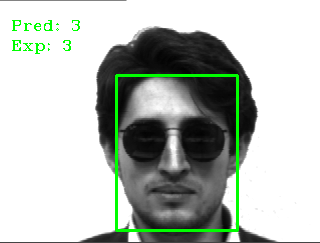

In [ ]:
cv2.putText(imagem, 'Pred: ' + str(previsao[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
cv2.putText(imagem, 'Exp: ' + str(saida_esperada), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
cv2_imshow(imagem)

In [31]:
def teste_reconhecimento(imagem_teste, classificador, show_conf = False):
  face, imagem_np = detecta_face(network, imagem_teste)
  previsao, conf = classificador.predict(face)
  saida_esperada = int(os.path.split(imagem_teste)[1].split('.')[0].replace('subject', ''))
  cv2.putText(imagem_np, 'Pred: ' + str(previsao), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  cv2.putText(imagem_np, 'Exp: ' + str(saida_esperada), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  if show_conf:
    print(conf)

  return imagem_np, previsao

2294.710531100637


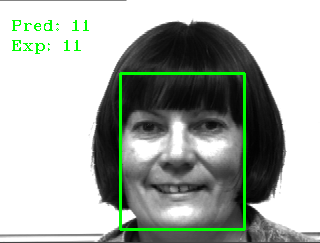

In [32]:
imagem_teste = '/content/yalefaces/test/subject11.happy.gif'
imagem_np, previsao = teste_reconhecimento(imagem_teste, eigen_classifier, True)
cv2_imshow(imagem_np)

### Avaliação do algoritmo 

In [33]:
def avalia_algoritmo(paths, classificador):
  previsoes = []
  saidas_esperadas = []
  for path in paths:
    face, imagem = detecta_face(network, path)
    previsao, conf = classificador.predict(face)
    saida_esperada = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    previsoes.append(previsao)
    saidas_esperadas.append(saida_esperada)
  return np.array(previsoes), np.array(saidas_esperadas)

In [34]:
paths_teste = [os.path.join('/content/yalefaces/test', f) for f in os.listdir('/content/yalefaces/test')]
print(paths_teste)

['/content/yalefaces/test/subject14.normal.gif', '/content/yalefaces/test/subject13.sad.gif', '/content/yalefaces/test/subject08.normal.gif', '/content/yalefaces/test/subject11.glasses.gif', '/content/yalefaces/test/subject12.normal.gif', '/content/yalefaces/test/subject03.glasses.gif', '/content/yalefaces/test/subject10.sad.gif', '/content/yalefaces/test/subject01.gif', '/content/yalefaces/test/subject06.leftlight.gif', '/content/yalefaces/test/subject09.rightlight.gif', '/content/yalefaces/test/subject14.sad.gif', '/content/yalefaces/test/subject04.surprised.gif', '/content/yalefaces/test/subject03.leftlight.gif', '/content/yalefaces/test/subject13.sleepy.gif', '/content/yalefaces/test/subject15.rightlight.gif', '/content/yalefaces/test/subject02.leftlight.gif', '/content/yalefaces/test/subject12.rightlight.gif', '/content/yalefaces/test/subject10.centerlight.gif', '/content/yalefaces/test/subject15.sad.gif', '/content/yalefaces/test/subject05.sleepy.gif', '/content/yalefaces/test/su

In [35]:
previsoes, saidas_esperadas = avalia_algoritmo(paths_teste, eigen_classifier)

In [36]:
previsoes

array([14, 13,  8, 11, 12,  3, 10,  1,  8,  6, 14,  4, 15, 13,  1,  9, 12,
       10, 15,  5, 11,  1,  9,  5,  6, 14,  9,  7, 10, 13])

In [37]:
saidas_esperadas

array([14, 13,  8, 11, 12,  3, 10,  1,  6,  9, 14,  4,  3, 13, 15,  2, 12,
       10, 15,  5, 11,  1,  9,  5,  6,  4,  2,  7,  8,  7])

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(saidas_esperadas, previsoes)

0.7

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(saidas_esperadas, previsoes)
cm

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

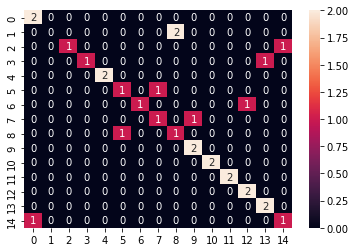

In [40]:
import seaborn
seaborn.heatmap(cm, annot=True);

### Parâmetros Eigenfaces

* **num_components**: número de eigenfaces -  Principal Component Analysis. Não existe uma regra geral para o número de componentes, sendo baseado nos dados de entrada. A documentação indica que 80 componentes em geral são suficientes

* **threshold**: confiança. Quanto maior o valor, menos o algoritmo vai requerer similiridade entre as faces

Quando o valor for maior do que o threshold, -1 será retornado (unknown). A confiança é uma distância entre a face de teste e a face mais próxima encontrada

Valor default: 1.7976931348623157e+308

> **num_components**

In [41]:
imagem_teste = '/content/yalefaces/test/subject07.happy.gif'

1845.5025871082807


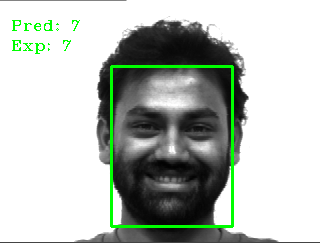

In [42]:
eigen_classifier_2 = cv2.face.EigenFaceRecognizer_create(40)
eigen_classifier_2.train(faces, ids)
imagem_np, prediction = teste_reconhecimento(imagem_teste, eigen_classifier_2, True)
cv2_imshow(imagem_np)

1238.0046271983003


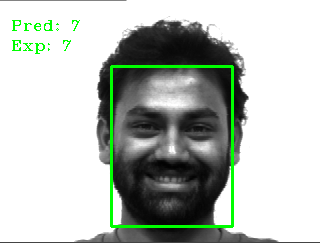

In [43]:
eigen_classifier_2 = cv2.face.EigenFaceRecognizer_create(20)
eigen_classifier_2.train(faces, ids)
imagem_np, prediction = teste_reconhecimento(imagem_teste, eigen_classifier_2, True)
cv2_imshow(imagem_np)

> **threshold**

1.7976931348623157e+308


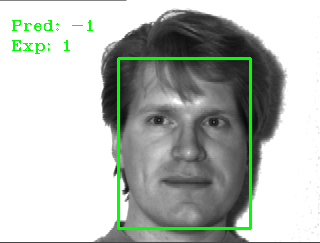

In [44]:
imagem_teste = '/content/yalefaces/test/subject01.gif'
eigen_classifier_2 = cv2.face.EigenFaceRecognizer_create(145, 2500)
eigen_classifier_2.train(faces, ids)
imagem_np, prediction = teste_reconhecimento(imagem_teste, eigen_classifier_2, True)
cv2_imshow(imagem_np)

In [45]:
def resultados_avaliacao(paths_teste, classificador):
  previsoes, saidas_esperadas = avalia_algoritmo(paths_teste, classificador)
  accuracy = accuracy_score(saidas_esperadas, previsoes)
  print(accuracy)
  cm = confusion_matrix(saidas_esperadas, previsoes)
  seaborn.heatmap(cm, annot = True)

0.6


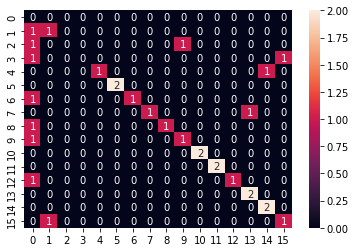

In [46]:
resultados_avaliacao(paths_teste, eigen_classifier_2)

## Fisherfaces

In [47]:
fisher_classifier = cv2.face.FisherFaceRecognizer_create()
fisher_classifier.train(faces, ids)
fisher_classifier.write('fisher_classifier.yml')

In [48]:
fisher_classifier = cv2.face.FisherFaceRecognizer_create()
fisher_classifier.read('/content/fisher_classifier.yml')

567.8583050127845


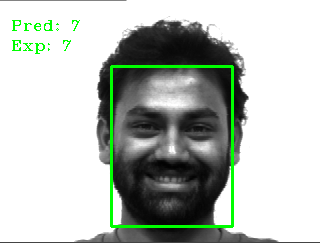

In [49]:
imagem_teste = '/content/yalefaces/test/subject07.happy.gif'
imagem_np, previsao = teste_reconhecimento(imagem_teste, fisher_classifier, True)
cv2_imshow(imagem_np)

### Avaliação do algoritmo

1.0


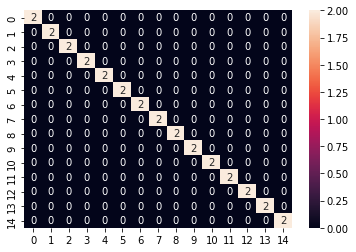

In [50]:
resultados_avaliacao(paths_teste, fisher_classifier)

### Parâmetros Fisherfaces

> **num_components**

261.3614473753749


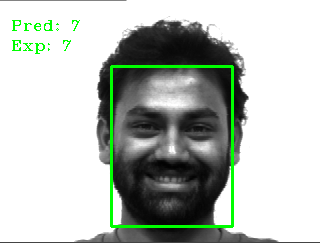

In [51]:
fisher_classifier_2 = cv2.face.FisherFaceRecognizer_create(5)
fisher_classifier_2.train(faces, ids)
imagem_teste = '/content/yalefaces/test/subject07.happy.gif'
imagem_np, previsao = teste_reconhecimento(imagem_teste, fisher_classifier_2, True)
cv2_imshow(imagem_np)

> **threshold**

567.8583050127845


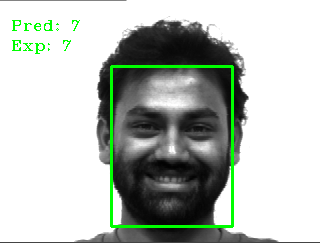

In [52]:
fisher_classifier_2 = cv2.face.FisherFaceRecognizer_create(20, 1000)
fisher_classifier_2.train(faces, ids)
imagem_teste = '/content/yalefaces/test/subject07.happy.gif'
imagem_np, previsao = teste_reconhecimento(imagem_teste, fisher_classifier_2, True)
cv2_imshow(imagem_np)

1.0


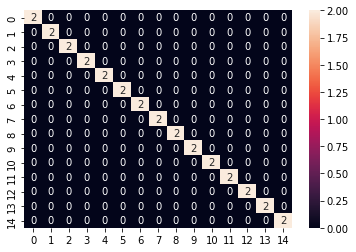

In [53]:
resultados_avaliacao(paths_teste, fisher_classifier_2)

## LBPH



In [54]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

In [55]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.read('/content/lbph_classifier.yml')

106.54436393093243


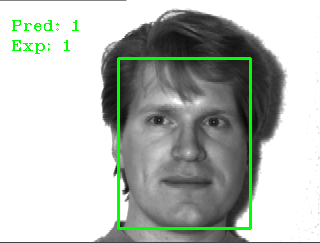

In [56]:
imagem_teste = '/content/yalefaces/test/subject01.gif'
imagem_np, previsao = teste_reconhecimento(imagem_teste, lbph_classifier, True)
cv2_imshow(imagem_np)

### Avaliação do algoritmo

0.8


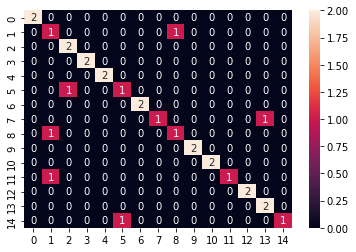

In [57]:
resultados_avaliacao(paths_teste, lbph_classifier)

### Parâmetros LBPH

* **radius** => É a distância do pixel central para os vizinhos. Se o raio aumenta, a região do cálculo fica maior mas deve perder alguns detalhes da imagem já que a região ficará mais dispersa

* **neighbors** => número de pontos para construir um padrão local. Enquanto o raio indica a abrangência, neighbors é usado para especificar quantos vizinhos serão considerados nos cálculos. Quanto maior o número de vizinhos, maior é o esforço computacional

* **grid_x** e **grid_y** => número de "patches" nas direções X e Y, que indicam as divisões na imagem. Por exemplo, em uma imagem 80x80 com a grade 8x8, serão utilizados 100 pixels por "pedaço" (10x10)

* **threshold** => indica a confiança

In [58]:
## valores padrões

# radius: 1
# neighbors: 8
# grid_x: 8
# grid_y: 8
# threshold: 1.7976931348623157e+308

> **radius**

143.5327387577211


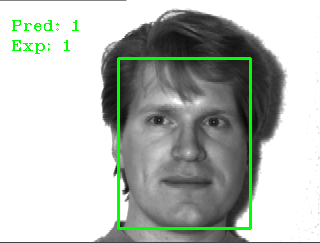

In [59]:
lbph_classifier_2 = cv2.face.LBPHFaceRecognizer_create(radius = 4)
lbph_classifier_2.train(faces, ids)
imagem_np, previsao = teste_reconhecimento(imagem_teste, lbph_classifier_2, True)
cv2_imshow(imagem_np)

0.8333333333333334


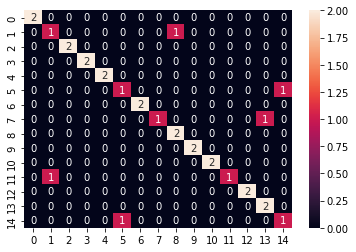

In [60]:
resultados_avaliacao(paths_teste, lbph_classifier_2)

> **neighbors**

178.2942236606237


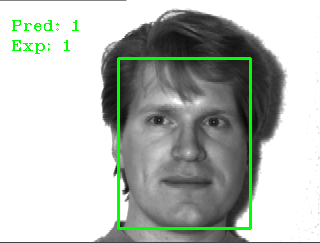

In [61]:
lbph_classifier_2 = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors = 12)
lbph_classifier_2.train(faces, ids)
imagem_np, previsao = teste_reconhecimento(imagem_teste, lbph_classifier_2, True)
cv2_imshow(imagem_np)

0.8


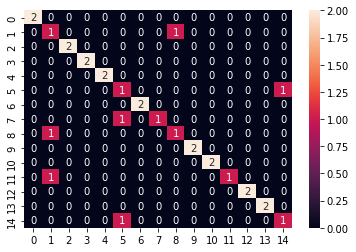

In [62]:
resultados_avaliacao(paths_teste, lbph_classifier_2)

> **grid_x** and **grid_y**

636.8123562325495


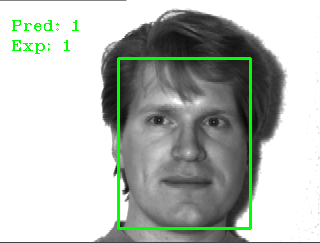

In [63]:
lbph_classifier_2 = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors = 12, grid_x=14, grid_y=14)
lbph_classifier_2.train(faces, ids)
imagem_np, previsao = teste_reconhecimento(imagem_teste, lbph_classifier_2, True)
cv2_imshow(imagem_np)

0.8333333333333334


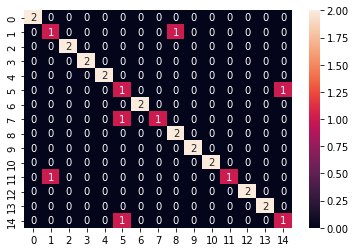

In [64]:
resultados_avaliacao(paths_teste, lbph_classifier_2)

> **threshold** 

1.7976931348623157e+308


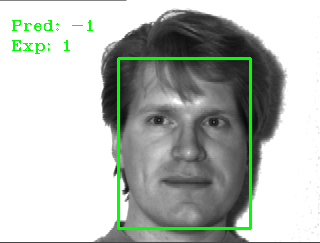

In [65]:
lbph_classifier_2 = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors = 12, 
                                                       grid_x=14, grid_y=14, threshold = 550)
lbph_classifier_2.train(faces, ids)
imagem_np, previsao = teste_reconhecimento(imagem_teste, lbph_classifier_2, True)
cv2_imshow(imagem_np)

0.6666666666666666


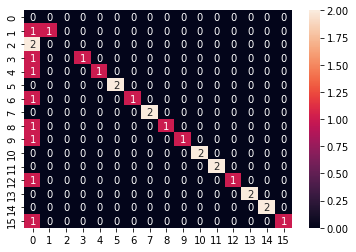

In [66]:
resultados_avaliacao(paths_teste, lbph_classifier_2)